## Introduction

### General
- Please read this [introductory notebook](https://colab.research.google.com/drive/1y3sRI1wC7qbWqN6skvulzPOp6xw8tLm7) to get familiar with the Brainwide dataset and the task structure.


Once this is done, please read the **specific instructions** below.

### What are the data of interest

#### Choice 💭
In this notebook, we will teach you how to run analysis, that will revolve around a variable of interest: the `choice`.

The choice is the decision the mouse makes to turn the wheel clock-wise (`CW`) or counter-clock-wise (`CCW`), in order to correctly bring a visual stimulus presented on the `left` or on the `right` to the center of the screen respectively.

The choice values are encoded and represented as:

*   value `+1` = CW (right), painted in blue
*   value `-1` = CCW (left), painted in red

The aim of this tutorial is to assess **whether** and **when** we can predict the choice of the animal.

#### Wheel ⭕

As we will want to predict the choice of the animal, we need to chose a time window that is not contaminated by movement. To check for such lack of movement, you will explore the `wheel` data, and plot its speed and position.

#### First movement 🔽
The time window for analysis will be taken **before** the turning of the wheel has started (as such turning is in itself indicative of the choice) . You will use the onset of the `first movement` as detected on the wheel trace to define your time window of interest.

#### Spikes and clusters 🧠
You will use the `spikes` from selected single-units (clusters). We will call these `units` throughout the text.

### What questions will each analysis answer

All of the analysis below use the neural activity in a time window of ~100ms before the first movement.

#### Encoding 🔛
If you were to rely on a single unit to predict the choice value, which one would you chose, and what would be the magnitude of the difference between its response to left or right choices?
- Note: This analysis concatenates the activity across trials

#### Manifold 📈
Using all units in a given brain region, when exactly would you be able to differentiate between the left or right choice in our time window of interest?
- Note: This analysis concatenates the activity across trials

#### Decoding ⏭
For a given trial, if you were a downstream neuron receiving the activity from all units in a given region as input, would you be able to differentiate left versus right choices?


#### Explore further 🌍
We will give at the end a set of ideas for you to explore the data further.


## Explore the data before you start

Important reference:
- You can see the data for the example recording through this [visualisation website](https://viz.internationalbrainlab.org/app?dset=bwm&pid=3675290c-8134-4598-b924-83edb7940269&tid=0&cid=935&qc=0).



Browse through a few trial in the `single trial overview` panel, and notice the timing between the different events, notably between the `stim on`, `first move` and `feedback`.

Notice how the wheel position changes during the trial: it is still before `stim on` and moves between the `first move` and `feedback`.

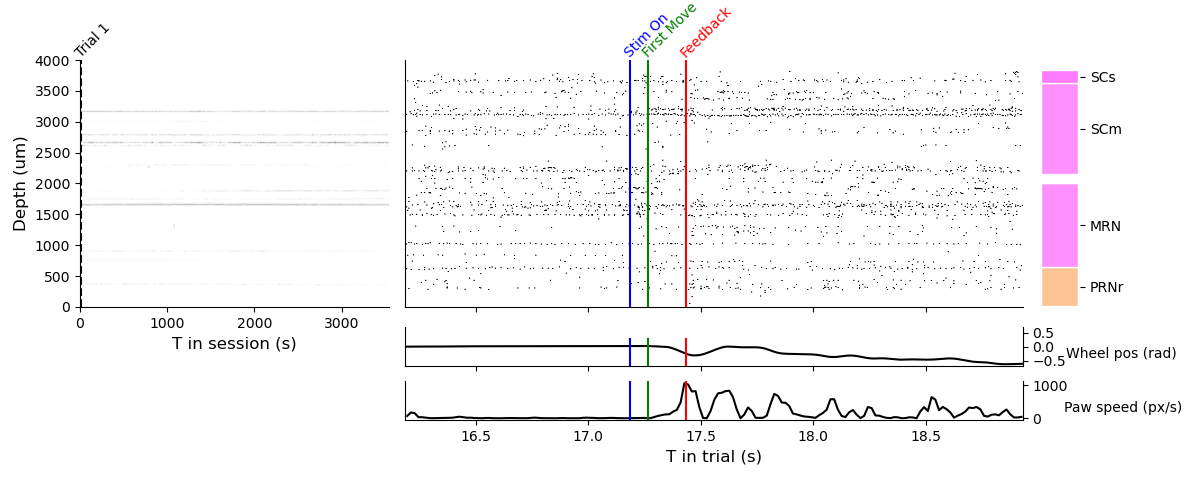

Notice that the wheel trace is very different between left and right choices, and that the wheel is nearly not moving before the first movement onset (dashed line):

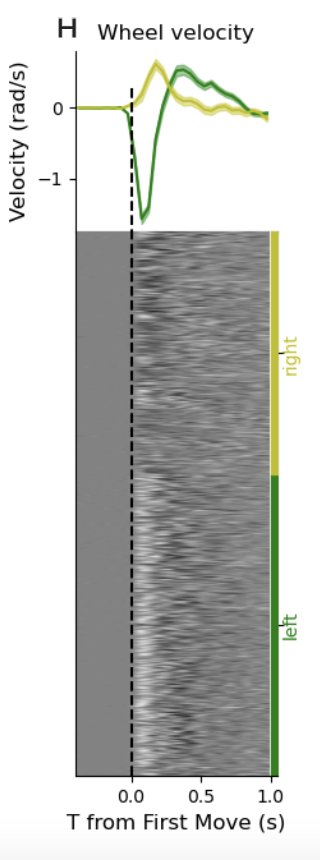


On the [website](https://viz.internationalbrainlab.org/app?dset=bwm&pid=3675290c-8134-4598-b924-83edb7940269&tid=0&cid=935&qc=0), browse the response of single good unit - here shown for unit #935.
You can see that some units are clearly responding selectively to a particular choice _after_ the first movement onset.

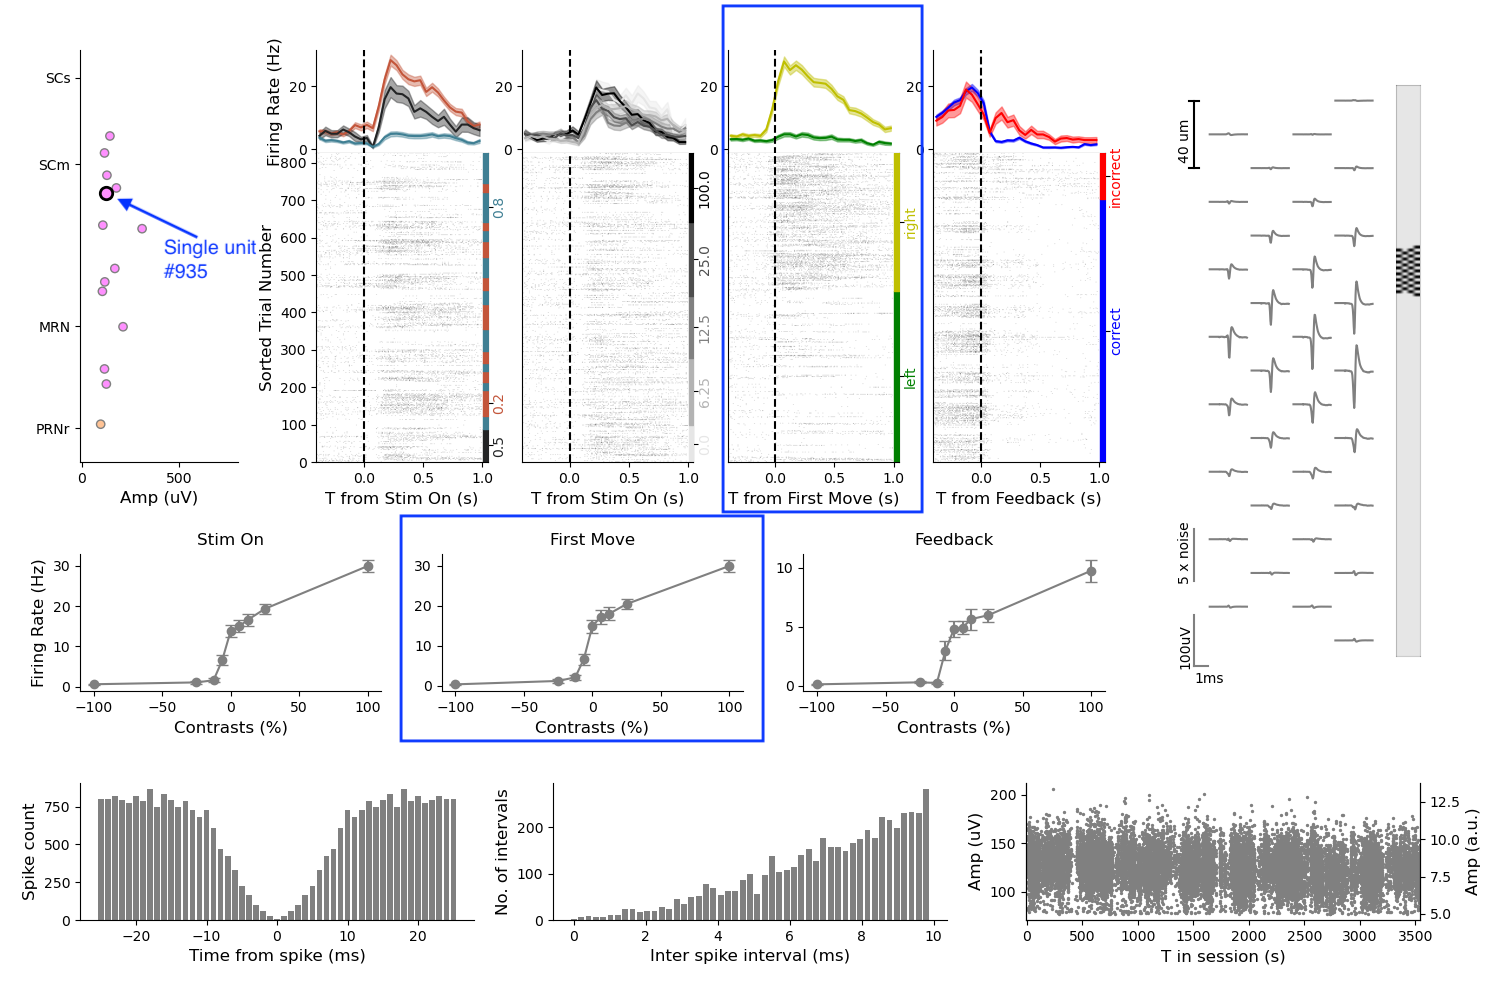

## Installation


References:
*   ONE install instructions: https://int-brain-lab.github.io/ONE/one_installation.html
*   BW main code repository: https://github.com/int-brain-lab/paper-brain-wide-map


1.   Install ONE and ibllib :



In [ ]:
!pip install ONE-api
!pip install ibllib

Run the cell and press enter all the way when answering to the prompts:

In [ ]:
# Instanciate the ONE cache
from pathlib import Path
ibl_cache = Path.home() / 'Downloads' / 'IBL_Cache'
ibl_cache.mkdir(exist_ok=True, parents=True)

# Setup the ONE API
#from one.api import ONE
#ONE.setup()

2.   Install BW specific packages:



In [ ]:
!git clone -b imbizo https://github.com/int-brain-lab/paper-brain-wide-map.git

In [ ]:
%cd /content/paper-brain-wide-map
!pip install -e .

## Code init and data selection



Useful references:


*   Use the `pid2eid` function to convert your probe unique identifier to session identified (eid) and probe name
(documentation [link](https://int-brain-lab.github.io/ONE/_autosummary/one.api.html#one.api.OneAlyx.pid2eid))
*  Use the `SessionLoader` to load trials data (documentation [link](https://int-brain-lab.github.io/iblenv/notebooks_external/loading_trials_data.html))
*  Use the `SpikeSortingLoader` to download spikes data (documentation [link](https://int-brain-lab.github.io/iblenv/notebooks_external/loading_spikesorting_data.html))

### Imports and inits


In [ ]:
# ---------------------------------------------------
# Init
from one.api import ONE
from brainbox.population.decode import get_spike_counts_in_bins
from brainbox.io.one import SpikeSortingLoader, SessionLoader
from brainbox.ephys_plots import plot_brain_regions
from brainbox.behavior.wheel import velocity
from brainbox.task.trials import get_event_aligned_raster, get_psth
from iblatlas.atlas import AllenAtlas
from brainwidemap import bwm_query
from brainwidemap.imbizo.encoding_functions import get_choice_time_shuffle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

one = ONE(base_url='https://openalyx.internationalbrainlab.org', \
          password='international', silent=True, cache_dir=ibl_cache)

ba = AllenAtlas()

Get BW dataframe to see what probe insertions (PID) are available.

In [ ]:
df_bw = bwm_query()
print(df_bw.to_markdown())

Loading bwm_query results from fixtures/2023_12_bwm_release.csv
|     | pid                                  | eid                                  | probe_name   |   session_number | date       | subject       | lab                |
|----:|:-------------------------------------|:-------------------------------------|:-------------|-----------------:|:-----------|:--------------|:-------------------|
|   0 | 56f2a378-78d2-4132-b3c8-8c1ba82be598 | 6713a4a7-faed-4df2-acab-ee4e63326f8d | probe00      |                1 | 2020-02-18 | NYU-11        | angelakilab        |
|   1 | 47be9ae4-290f-46ab-b047-952bc3a1a509 | 56956777-dca5-468c-87cb-78150432cc57 | probe01      |                1 | 2020-02-21 | NYU-11        | angelakilab        |
|   2 | 6be21156-33b0-4f70-9a0f-65b3e3cd6d4a | 56956777-dca5-468c-87cb-78150432cc57 | probe00      |                1 | 2020-02-21 | NYU-11        | angelakilab        |
|   3 | 8dfb86c8-d45c-46c4-90ec-33078014d434 | 4364a246-f8d7-4ce7-ba23-a098104b96e4 | 

Download the data necessary for the analysis:

In [ ]:
# ---------------------------------------------------
# Select your PID
pid = '3675290c-8134-4598-b924-83edb7940269'

# ---------------------------------------------------
# Convert probe PID to session EID and probe name
[eid, pname] = one.pid2eid(pid)

# ---------------------------------------------------
# Load spike data
ssl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
spikes, clusters, channels = ssl.load_spike_sorting()
clusters = ssl.merge_clusters(spikes, clusters, channels)

# ---------------------------------------------------
# Restrict to only good clusters
# Find the good cluster index:
good_cluster_idx = clusters['label'] == 1
good_cluster_IDs = clusters['cluster_id'][good_cluster_idx]
# Filter the clusters accordingly:
clusters_g = {key: val[good_cluster_idx] for key, val in clusters.items()}
# Filter the spikes accordingly:
good_spk_indx = np.where(np.isin(spikes['clusters'], good_cluster_IDs))
spikes_g = {key: val[good_spk_indx] for key, val in spikes.items()}

# ---------------------------------------------------
# N neuronal units in total
num_neuron = len(np.unique(spikes_g['clusters']))

# ---------------------------------------------------
# Load trial data
sl = SessionLoader(eid=eid, one=one)
sl.load_trials()
events = sl.trials['firstMovement_times']

# If event == NaN, remove the trial from the analysis
nan_index = np.where(np.isnan(events))[0]
events = events.drop(index=nan_index).to_numpy()
contrast_R = sl.trials.contrastRight.drop(index=nan_index).to_numpy()
contrast_L = sl.trials.contrastLeft.drop(index=nan_index).to_numpy()
choice = sl.trials.choice.drop(index=nan_index).to_numpy()
block = sl.trials.probabilityLeft.drop(index=nan_index).to_numpy()

# N trial count
num_trial = len(events)

# Find "trials" that go in one direction and the other direction
# Note: This is not a pure indexing on the *task trials* as we removed trials with nan values previously
indx_choice_a = np.where(choice == -1)[0]
indx_choice_b = np.where(choice == 1)[0]

# ---------------------------------------------------
# Load wheel data
sl.load_wheel()
wheel_times = sl.wheel['times'].values
wheel_position = sl.wheel['position'].values
speed = sl.wheel['velocity'].values

## Encoding

### Introduction

Here we want to assess whether **single units encode the choice of the animal** (i.e. turning the wheel left or right).

To not be confounded by the encoding of the movement itself, we will use the neural activity solely in a narrow time-window *prior* to the first mouvement onset as detected on the wheel trace.

We will compute in this time window the `modulation index`, i.e. the change in firing rate between the trials where the animal turned the wheel left or right.

We will assess the *significance* of such modulation by doing complex permutation tests.

Useful references:

*   Use the `get_spike_counts_in_bins` function from brainbox to get the spikes around a specific time event (documentation [link](https://int-brain-lab.github.io/iblenv/_modules/brainbox/population/decode.html))

*  [Code](https://github.com/int-brain-lab/paper-brain-wide-map/blob/imbizo/brainwidemap/imbizo/encoding_functions.py) to assess significance from Yanliang Shi

### Analysis

Here we use a time window of 100ms prior to the first movement onset:

In [ ]:
# ---------------------------------------------------
# Select a time window of interest
time_window = np.array([-0.1, 0.0])  # 100 ms before the event

Let's display the wheel position and speed for the first 4 trials, to see where the time window is compared to it:

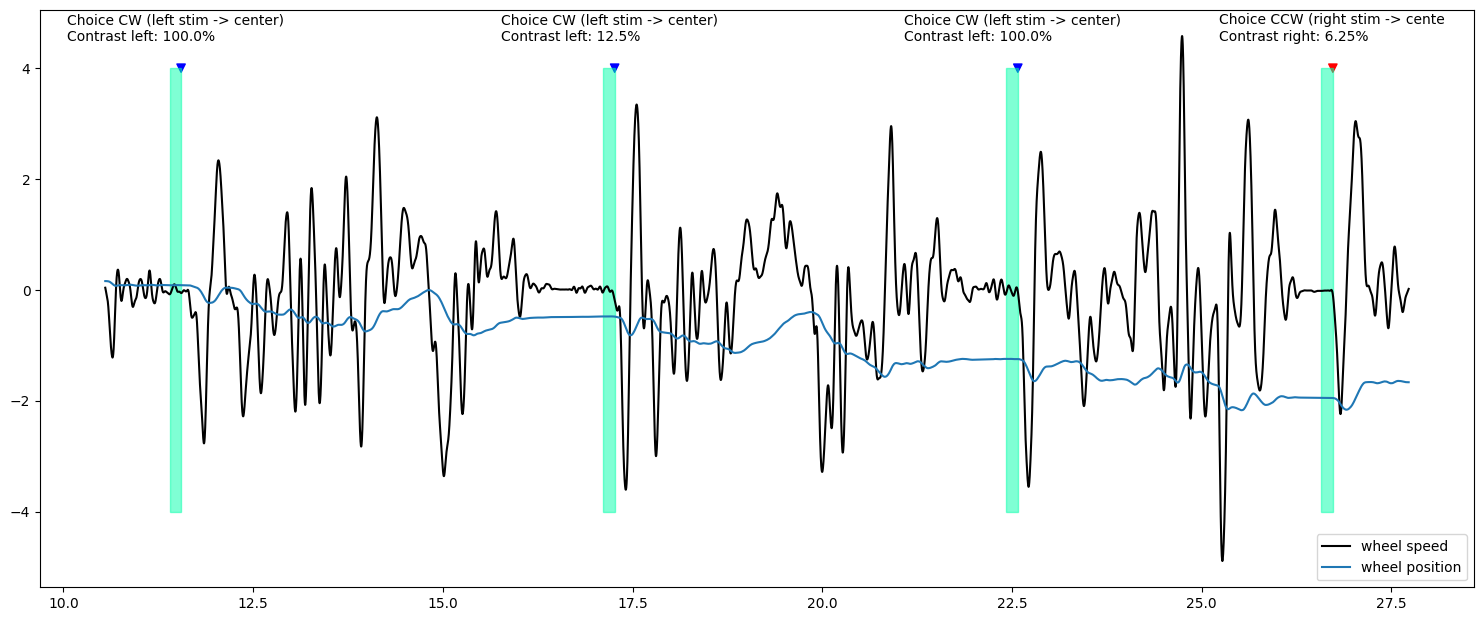

In [ ]:
# ---------------------------------------------------
# Plot the whole wheel trace for the first N events in the task
n_ev_plt = 4
indx_plot = np.where((wheel_times > events[0] - 1.0) & (wheel_times < events[n_ev_plt-1] + 1.0))

# Positive wheel speed indicate a CCW (left stim) move
# -1 (turn CCW), +1 (turn CW), or 0 (nogo)
choice_text = np.repeat('CW (left stim -> center)', n_ev_plt)
choice_text[np.where(choice[0:n_ev_plt] == -1)] = 'CCW (right stim -> center)'
# We represent left choice in red / right choice in blue
choice_color = np.repeat('#0000FF', n_ev_plt)
choice_color[np.where(choice[0:n_ev_plt] == -1)] = '#FF0000'

fig, ax = plt.subplots(1)
fig.set_size_inches(18.5, 7.5)

plt.plot(wheel_times[indx_plot], speed[indx_plot], 'k', label='wheel speed')
plt.plot(wheel_times[indx_plot], wheel_position[indx_plot], label='wheel position')
plt.scatter(events[0:n_ev_plt], 4*np.ones(events[0:n_ev_plt].shape), color=choice_color, marker='v')

for i_ev_plt in range(0, n_ev_plt):
    if not np.isnan(contrast_R[i_ev_plt]):
        contrast_text = f'Contrast right: {contrast_R[i_ev_plt]*100}%'
    else:
        contrast_text = f'Contrast left: {contrast_L[i_ev_plt] * 100}%'

    txt = f'Choice {choice_text[i_ev_plt]} \n{contrast_text}'
    ax.annotate(txt, (events[i_ev_plt]-1.5, 4.5))


# Highlight the part where the ephys data is taken with rectangles
for event in events[0:n_ev_plt]:
    ax.add_patch(Rectangle((event+time_window[0], -4), width=time_window[1]-time_window[0],
                           height=8, alpha=0.5, color='#00FFAA', edgecolor=None))

ax.legend(loc=4)

Now we compute the spike rate around our event of interest (first movement), and then the `modulation index` indicating the magnitude of the change in firing rate between the two conditions (choice left or right). A high absolute value of the `modulation index` indicates a strong change between the firing in the two conditions, and therefore a potential encoding.

We also perform a significance test to obtain a p-value showing whether the activity is different for left versus right choices :

In [ ]:
# ---------------------------------------------------
# Compute spike rate around event
events_tw = np.array([events+time_window[0], events+time_window[1]]).T

# Compute count (for all clusters of interest) (THIS CAN TAKE A WHILE)
spike_count, cluster_id = get_spike_counts_in_bins(spikes_g['times'], spikes_g['clusters'], events_tw)

# Compute rate (for all clusters of interest)
spike_rate = np.zeros((num_neuron, num_trial))
spike_rate = spike_count / (time_window[1] - time_window[0])

# ---------------------------------------------------
# Compute the modulation index
modulation_index = np.divide((np.mean(spike_rate[:, indx_choice_a], 1) - np.mean(spike_rate[:, indx_choice_b], 1)),
                             (np.mean(spike_rate[:, indx_choice_a], 1) + np.mean(spike_rate[:, indx_choice_b], 1)))


In [ ]:
# ---------------------------------------------------
# Compute p-value to assess significance of encoding (THIS CAN TAKE A WHILE)
p_1 = get_choice_time_shuffle(spike_rate, contrast_L, contrast_R, block, choice, 1000)
# Find those that are significant to 0.01
p_sig = np.zeros(p_1.shape)
p_sig[np.where(p_1 < 0.01)] = 1

Now we plot the `modulation index` value for each neuron along the probe depth, colored according to the level of significance.
We can see that a few units are significantly modulated.

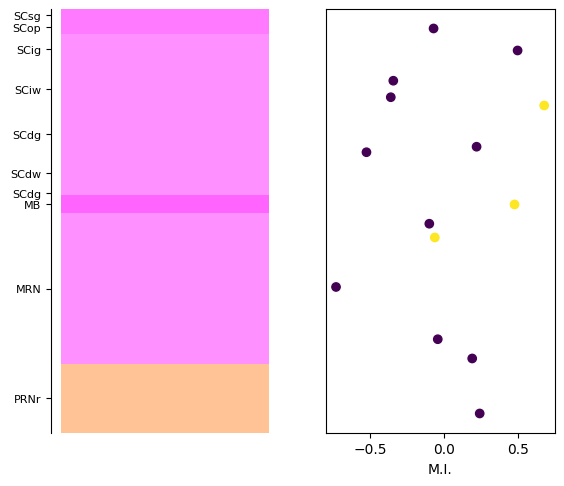

In [ ]:
# ---------------------------------------------------
# Plot the modulation index for each unit across brain regions
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(6.5, 5.5)
# Plot the brain regions through which the channels on the insertion pass
plot_brain_regions(channels['atlas_id'], channel_depths=channels['axial_um'], ax=axs[0])
# Plot scatter plot of cluster depths vs cluster modulation index
axs[1].scatter(modulation_index, clusters_g['depths'], c=p_sig)  # color by significance
axs[1].set_xlabel('M.I.')
axs[1].get_yaxis().set_visible(False)

Note to go further:


*   This analysis can be done using any time window, or any events. As such, you can try to see if units are also selective to left / right conditions _after_ the first move, or _after_ the stimulus onset for example.



## Manifold

### Introduction

In the above example (Encoding), we looked at whether units encoded significantly the choice (left or right) using their firing rate in a time window before the first movement.

Now, we will study **_when_ the neural activity representing left or right choices differs** before the first movement.

We will use a dimentionality approach (Manifold) to measure the distance between the left and right choice representation during the time window of interest.

The manifold analysis steps are:  (see figure below)
- **a)** For each unit, take the spikes before the first movement in a time window, and create a PSTH for left and right choices
- **b)** Stack these average PSTHs across units so as to form a high-dimentional representation of the choice (N dimension = N units)
- **c)** Reduce these PSTHs to a lower-dimention state space, e.g. through PCA, and plot the trajectories in that space (using e.g. the first 3 PCs)
-  **d)** Compute the distance between the reduced trajectories at each timepoint, and assess the significance of the distance (which would mean, whether the units represent the choice left/right above chance)
- **e)** Find the time point for which the distance is at a percentage (e.g. 70%) of the maximal distance (`latency`)
   - Note: do not use the absolute max otherwise most latencies will be at the first movement time

In **(c-e)** we show you the results for all units in the region GRN (gigantocellular reticular nucleus). To do this, we had to load units from multiple probe insertions targeting the GRN.

In **(f-g)** we show you the result for all regions of the Brainwide map. The code to reproduce this figure written by Michael Schartner is [here](https://github.com/int-brain-lab/paper-brain-wide-map/blob/imbizo/brainwidemap/manifold/README.md).

Note: This analysis can be done using single-units for a given region from a single PID as is done in the example below, however it works best if you stack as many PSTHs as possible. As such, it is better to first load the spikes data from many recordings spanning a region of interest at once.

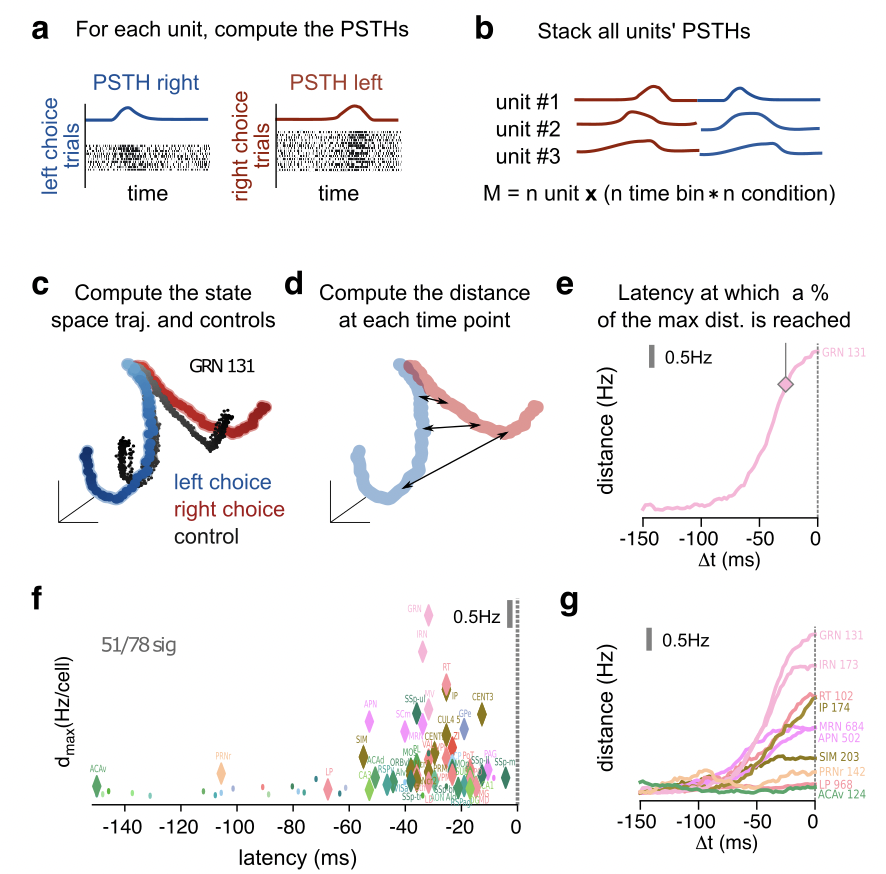

### Analysis

Here we will do a much simplified version of the analysis, without any control to show you how to start simply.

We will use PCA, and focus only on units in the motor-area of the Superior Colliculus (SCm).

Useful references:
- Use the `get_event_aligned_raster` and `get_psth` functions to create PSTHs (documentation [here](https://int-brain-lab.github.io/iblenv/_autosummary/brainbox.task.trials.html#brainbox.task.trials.get_psth))
- Examples of different brain region mapping (Allen or Beryl) can be found [here](https://int-brain-lab.github.io/iblenv/notebooks_external/atlas_mapping.html)

Select the units in a given brain region (here `SCm`):

In [ ]:
# ---------------------------------------------------
# Select units in a given brain region

# Remap the channel acronyms to the Beryl brain region parcellation (which is a higher order)
region_acr_ch = ba.regions.id2acronym(channels['atlas_id'], mapping='Beryl')
cluster_g_acr = region_acr_ch[clusters_g['channels']]
# Print each unit's brain region label
print(cluster_g_acr)

# Take the index of units in SCm
indx_scm = np.where(cluster_g_acr == 'SCm')[0]
cluster_SCm_IDs = good_cluster_IDs[indx_scm]
nunit = len(cluster_SCm_IDs)

['PRNr' 'MRN' 'MRN' 'MRN' 'MRN' 'MRN' 'MRN' 'SCm' 'SCm' 'SCm' 'SCm' 'SCm'
 'SCm' 'SCm']


**(a-b)** Create stacked PSTHs (using all cells):

In [ ]:

# ---------------------------------------------------
# Create PSTHs
binsize = 0.01  # bin size [sec] for neural binning
time_window = [-0.150, 0]

for count, clu_id in enumerate(cluster_SCm_IDs):

    # Find spikes for this cluster
    spk_indx = np.where(np.isin(spikes_g['clusters'], clu_id))
    spikes_unit = {key: val[spk_indx] for key, val in spikes_g.items()}

    # Compute raster
    raster, timestamps = get_event_aligned_raster(spikes_unit['times'], events, tbin=binsize, values=None,
                                                  epoch=time_window, bin=True)
    # Compute PSTH (return only the mean)
    psth_a, _ = get_psth(raster, trial_ids=indx_choice_a)
    psth_b, _ = get_psth(raster, trial_ids=indx_choice_b)

    # ------- Stack PSTHs -------
    # Init ; Here we create a M = n condition x n unit x n time bin and will concatenate it later
    if count == 0:
        nbin = len(timestamps)
        stack_psth = np.empty((2, nunit, nbin))

    stack_psth[0, count, :] = psth_a
    stack_psth[1, count, :] = psth_b

Plot the stacked PSTHs:

[Text(0, 0, 'unit #1')]

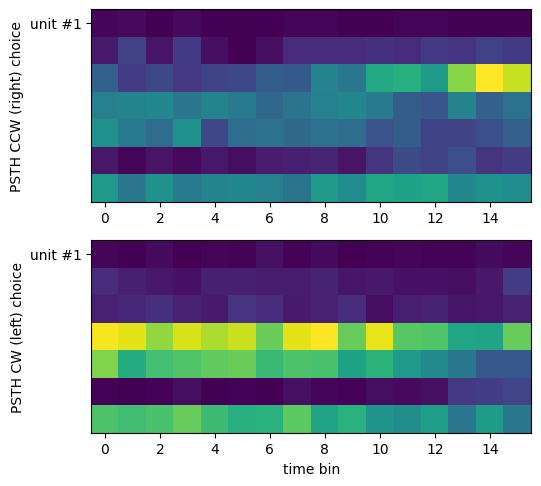

In [ ]:
# ---------------------------------------------------
# Plot stacked PSTHs
fig, ax = plt.subplots(2)
fig.set_size_inches(6.5, 5.5)
ax[0].imshow(stack_psth[0, :, :], vmax=stack_psth.max(), vmin=stack_psth.min())
ax[1].imshow(stack_psth[1, :, :], vmax=stack_psth.max(), vmin=stack_psth.min())
ax[0].set_xlabel('')
ax[1].set_xlabel('time bin')
ax[0].set_ylabel('PSTH CCW (right) choice')
ax[1].set_ylabel('PSTH CW (left) choice')

ytick_loc = [0]
ax[0].set_yticks(ytick_loc)
ax[1].set_yticks(ytick_loc)
ax[0].set_yticklabels(['unit #1'])
ax[1].set_yticklabels(['unit #1'])

**(c)** Generate state space:

In [ ]:
# ---------------------------------------------------
# Perform PCA
pca = PCA(n_components=2)
# Use concatenate to place the PSTHs of the two conditions one after the other in time
# Transpose before doing the PCA, so it's done on the unit axis
trajs = pca.fit_transform(np.concatenate(stack_psth, axis=1).T).T

# ---------------------------------------------------
# Take trajectory per condition
traj_a = trajs[:, 0:nbin]
traj_b = trajs[:, nbin:]

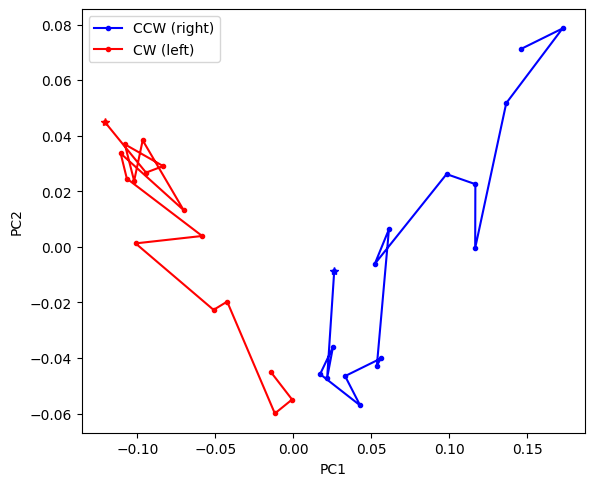

In [ ]:
# ---------------------------------------------------
# Plot the trajectories
fig, ax = plt.subplots(1)
fig.set_size_inches(6.5, 5.5)
ax.plot(traj_a[0, :], traj_a[1, :], color='b', label='CCW (right)',  marker='.')
ax.plot(traj_b[0, :], traj_b[1, :], color='r', label='CW (left)',  marker='.')
# Mark the start
ax.plot(traj_a[0, 0], traj_a[1, 0], color='b', marker='*')
ax.plot(traj_b[0, 0], traj_b[1, 0], color='r', marker='*')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(loc=2)

Let's now compute and plot the Euclidian distance between the two trajectories:

Text(0, 0.5, 'Euclidian distance')

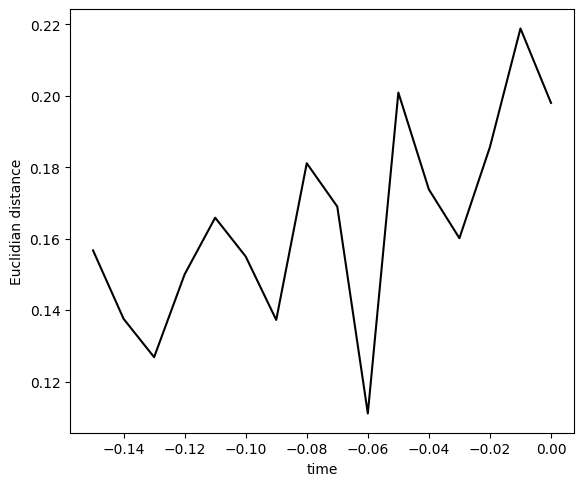

In [ ]:
# ---------------------------------------------------
# Compute the Euclidian distance
euc_dist = np.sqrt(np.sum((traj_a - traj_b) ** 2, axis=0))

# ---------------------------------------------------
# Plot the euclidian distance
fig, ax = plt.subplots(1)
fig.set_size_inches(6.5, 5.5)
ax.plot(timestamps, euc_dist, color='k', label='SCm')
ax.set_xlabel('time')
ax.set_ylabel('Euclidian distance')

Note that this is rather wobbly -- using more cells from other PIDs would help smoothen the curves.

## Decoding

In this example, we will want to decode the choice for a given trial, using the activity of several units (you can select units from a chosen brain region, here for simplicity we use all units).

As the choice is a binary variable (`+1, -1`) we will use `logistic regression` in a high dimension space (defined by the number of units).

We will devise training and testing sets as is classically done to perform accuracy assessment in machine learning.

Useful reference:
-  To prepare test and training sets, use the [built-in `scikit-learn train_test_split` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [ ]:
# ---------------------------------------------------
# Check that there are indeed only 2 values in choice
assert len(np.unique(choice)) == 2

# ---------------------------------------------------
# Use the spike count in the time window prior to the movement onset as predictors.
# We use the same time window as defined earlier (Encoding)
X = spike_count.T  # shape of spike_count : n units x n trials in set -> transpose to fit model
y = choice

# ---------------------------------------------------
# Split trials into test and training sets for the logistic regression.
# Take first half of trials for training, second half for testing (test_size = 0.5)
# Fix random seed to repeat results across runs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# ---------------------------------------------------
# See how many trials there is for choice +1 ; -1
print(f'Training set : {len(np.where(y_train == 1)[0])} choice +1 / {len(y_train)} trials')
print(f'Testing set : {len(np.where(y_test == 1)[0])} choice +1 / {len(y_test)} trials')

Training set : 255 choice +1 / 410 trials
Testing set : 224 choice +1 / 410 trials


In [ ]:
# ---------------------------------------------------
# Fit the logistic regression model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Use the test set to assess the model accuracy
choice_predicted = clf.predict(X_test)
n_trial_correct = len(np.where(y_test == choice_predicted)[0])
print(f'Accuracy : {n_trial_correct} trials correctly predicted / {len(y_test)} trials')

Accuracy : 293 trials correctly predicted / 410 trials


Note to go further:

Here we split the trials half/half for training and testing set. To get a better sense for accuracy, you could train using all but 1 trial (leave-one-out), and run the same analysis as above in a loop over all trials - this way, you would use as much information as possible to fit the logistic regression.

References

- A much more thorough analysis example can be found [here](https://github.com/int-brain-lab/paper-brain-wide-map/blob/decoding_initial/brainwidemap/decoding/decoding_example_script.py); [here is the link](https://github.com/int-brain-lab/paper-brain-wide-map/blob/decoding_initial/brainwidemap/decoding/functions/decoding.py#L312) to its most inner fitting function; code written by Matt Whiteway and Brandon Benson.

## More ideas


### 📗 We studied choice - what about other binary variables?



Are you interested to know how units encode other variables, such as the reward or the visual stimulus ?

You can run similar analysis as the **Encoding, Manifold and Decoding**, but for other types of binary variables present in the task (printed below), such as :
  - the `visual stimulus side` (presented on the left or right side of the screen)
  - the `feedback type` (reward or noise burst)
  - the `movement side` (CCW or CW)

Respectively, you can use these variables to create a time window of interest:
  - (0, +0.1) second from `stimOn_times`
  - (0, +0.1) second from `feedback_times`
  - (0, +0.1) second from `firstMovement_times`  (note that this time the window is ***after*** the first movement)

In [ ]:
sl.trials.keys()

Index(['goCueTrigger_times', 'stimOff_times', 'feedback_times',
       'response_times', 'contrastRight', 'probabilityLeft', 'goCue_times',
       'stimOn_times', 'firstMovement_times', 'rewardVolume', 'feedbackType',
       'choice', 'contrastLeft', 'intervals_0', 'intervals_1'],
      dtype='object')

We show you below **interesting brain regions** to look at using the example of the manifold analysis:

- In **(a)** is shown the trajectory of the brain region `GRN` for the choice, which was our example variable in this tutorial.
- In **(b)** are shown two examples regions, `VISp` and `IRN` that are encoding the `stimulus side` and `feedback type` respectively.
   - Note that the time window taken here is positive (i.e. after the stimulus or feedback onset), and much longer for the case of the feedback.
   - Note that IRN presents an oscillatory pattern which may be linked to licking.
   

Useful links:   
 - [Documentation](https://int-brain-lab.github.io/iblenv/notebooks_external/loading_video_data.html) on how to download the licking times (`licks`)
 - [Documentation](https://int-brain-lab.github.io/ONE/notebooks/useful_alyx_queries.html#list-experiments-spanning-channel-locations) on how to find a PID going through a brain region of interest ; you can also use this query, which returns a list of PIDs:
 ```
 pids = one.search_insertions(atlas_acronym='VISp', query_type='remote')


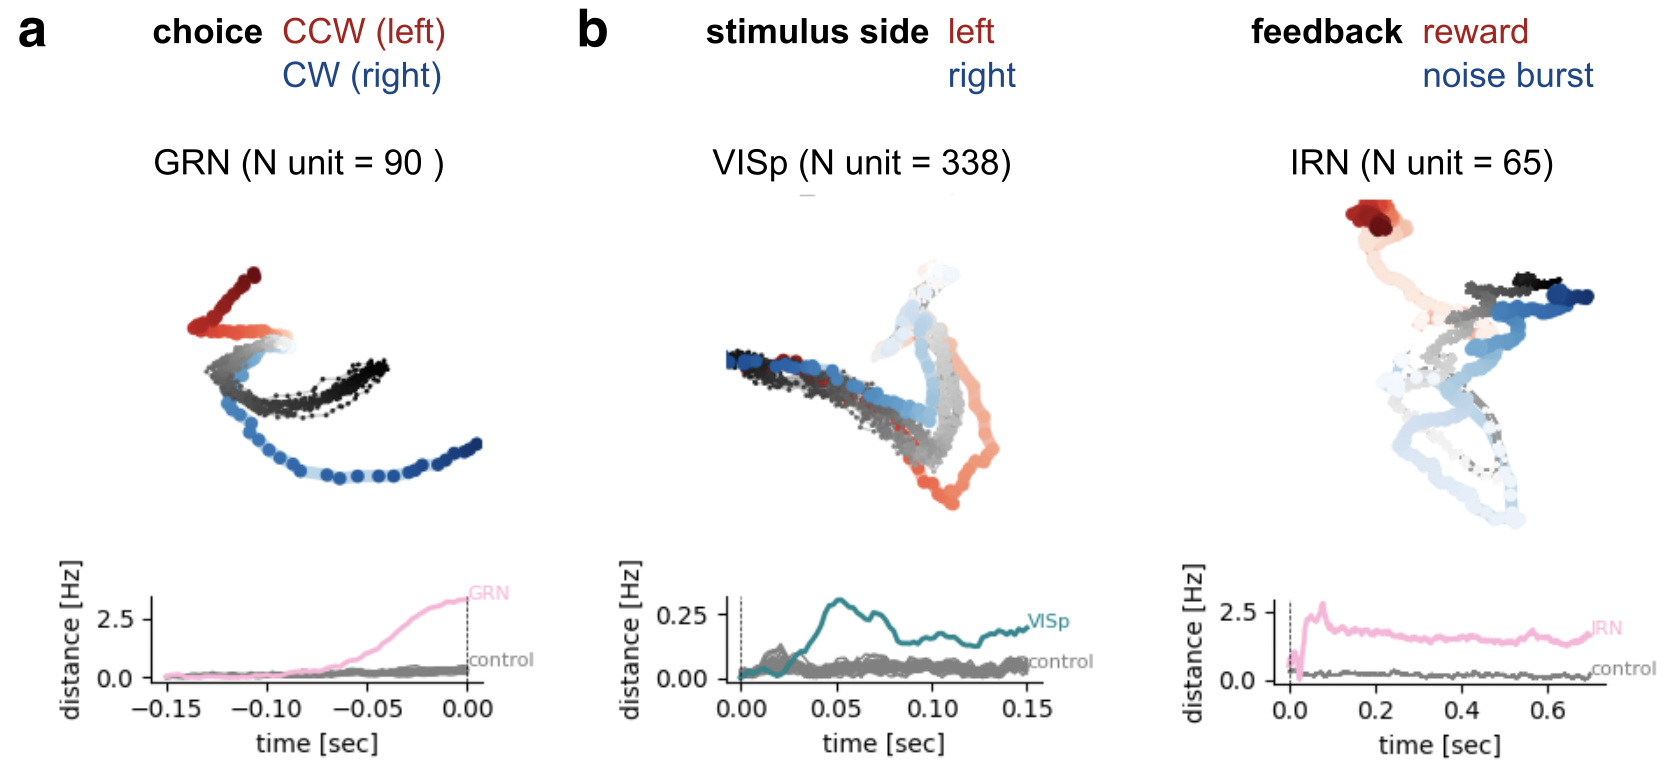

### 📙  Delineating mixed-responses using General Linear Model (GLM)


#### Introduction
In the Encoding example above, we showed you how to probe whether units were significantly modulated between two conditions of a given event in a specific time window (e.g. event: choice, condition: left vs right, time window: 100ms prior to the first movement).

However, units can be `modulated by several events in the task` (e.g. visual stimuli and choice). In our task these events often occur very close temporally, as the reaction time of the mouse can be as quick as a few hundreds of milliseconds.

To disambiguate the contribution of each task variables, you can fit response `kernels` mimicking the time course neural responses using a `General Linera Model (GLM)` to the real neural responses.

The weight of each kernel indicates how much a unit is responsive to a given task event.

#### Example figure and code

In the plot below, we show an example fit for several kernels to one unit. You can see this unit is mostly encoding the right stimulus onset, as most other kernels are flat.

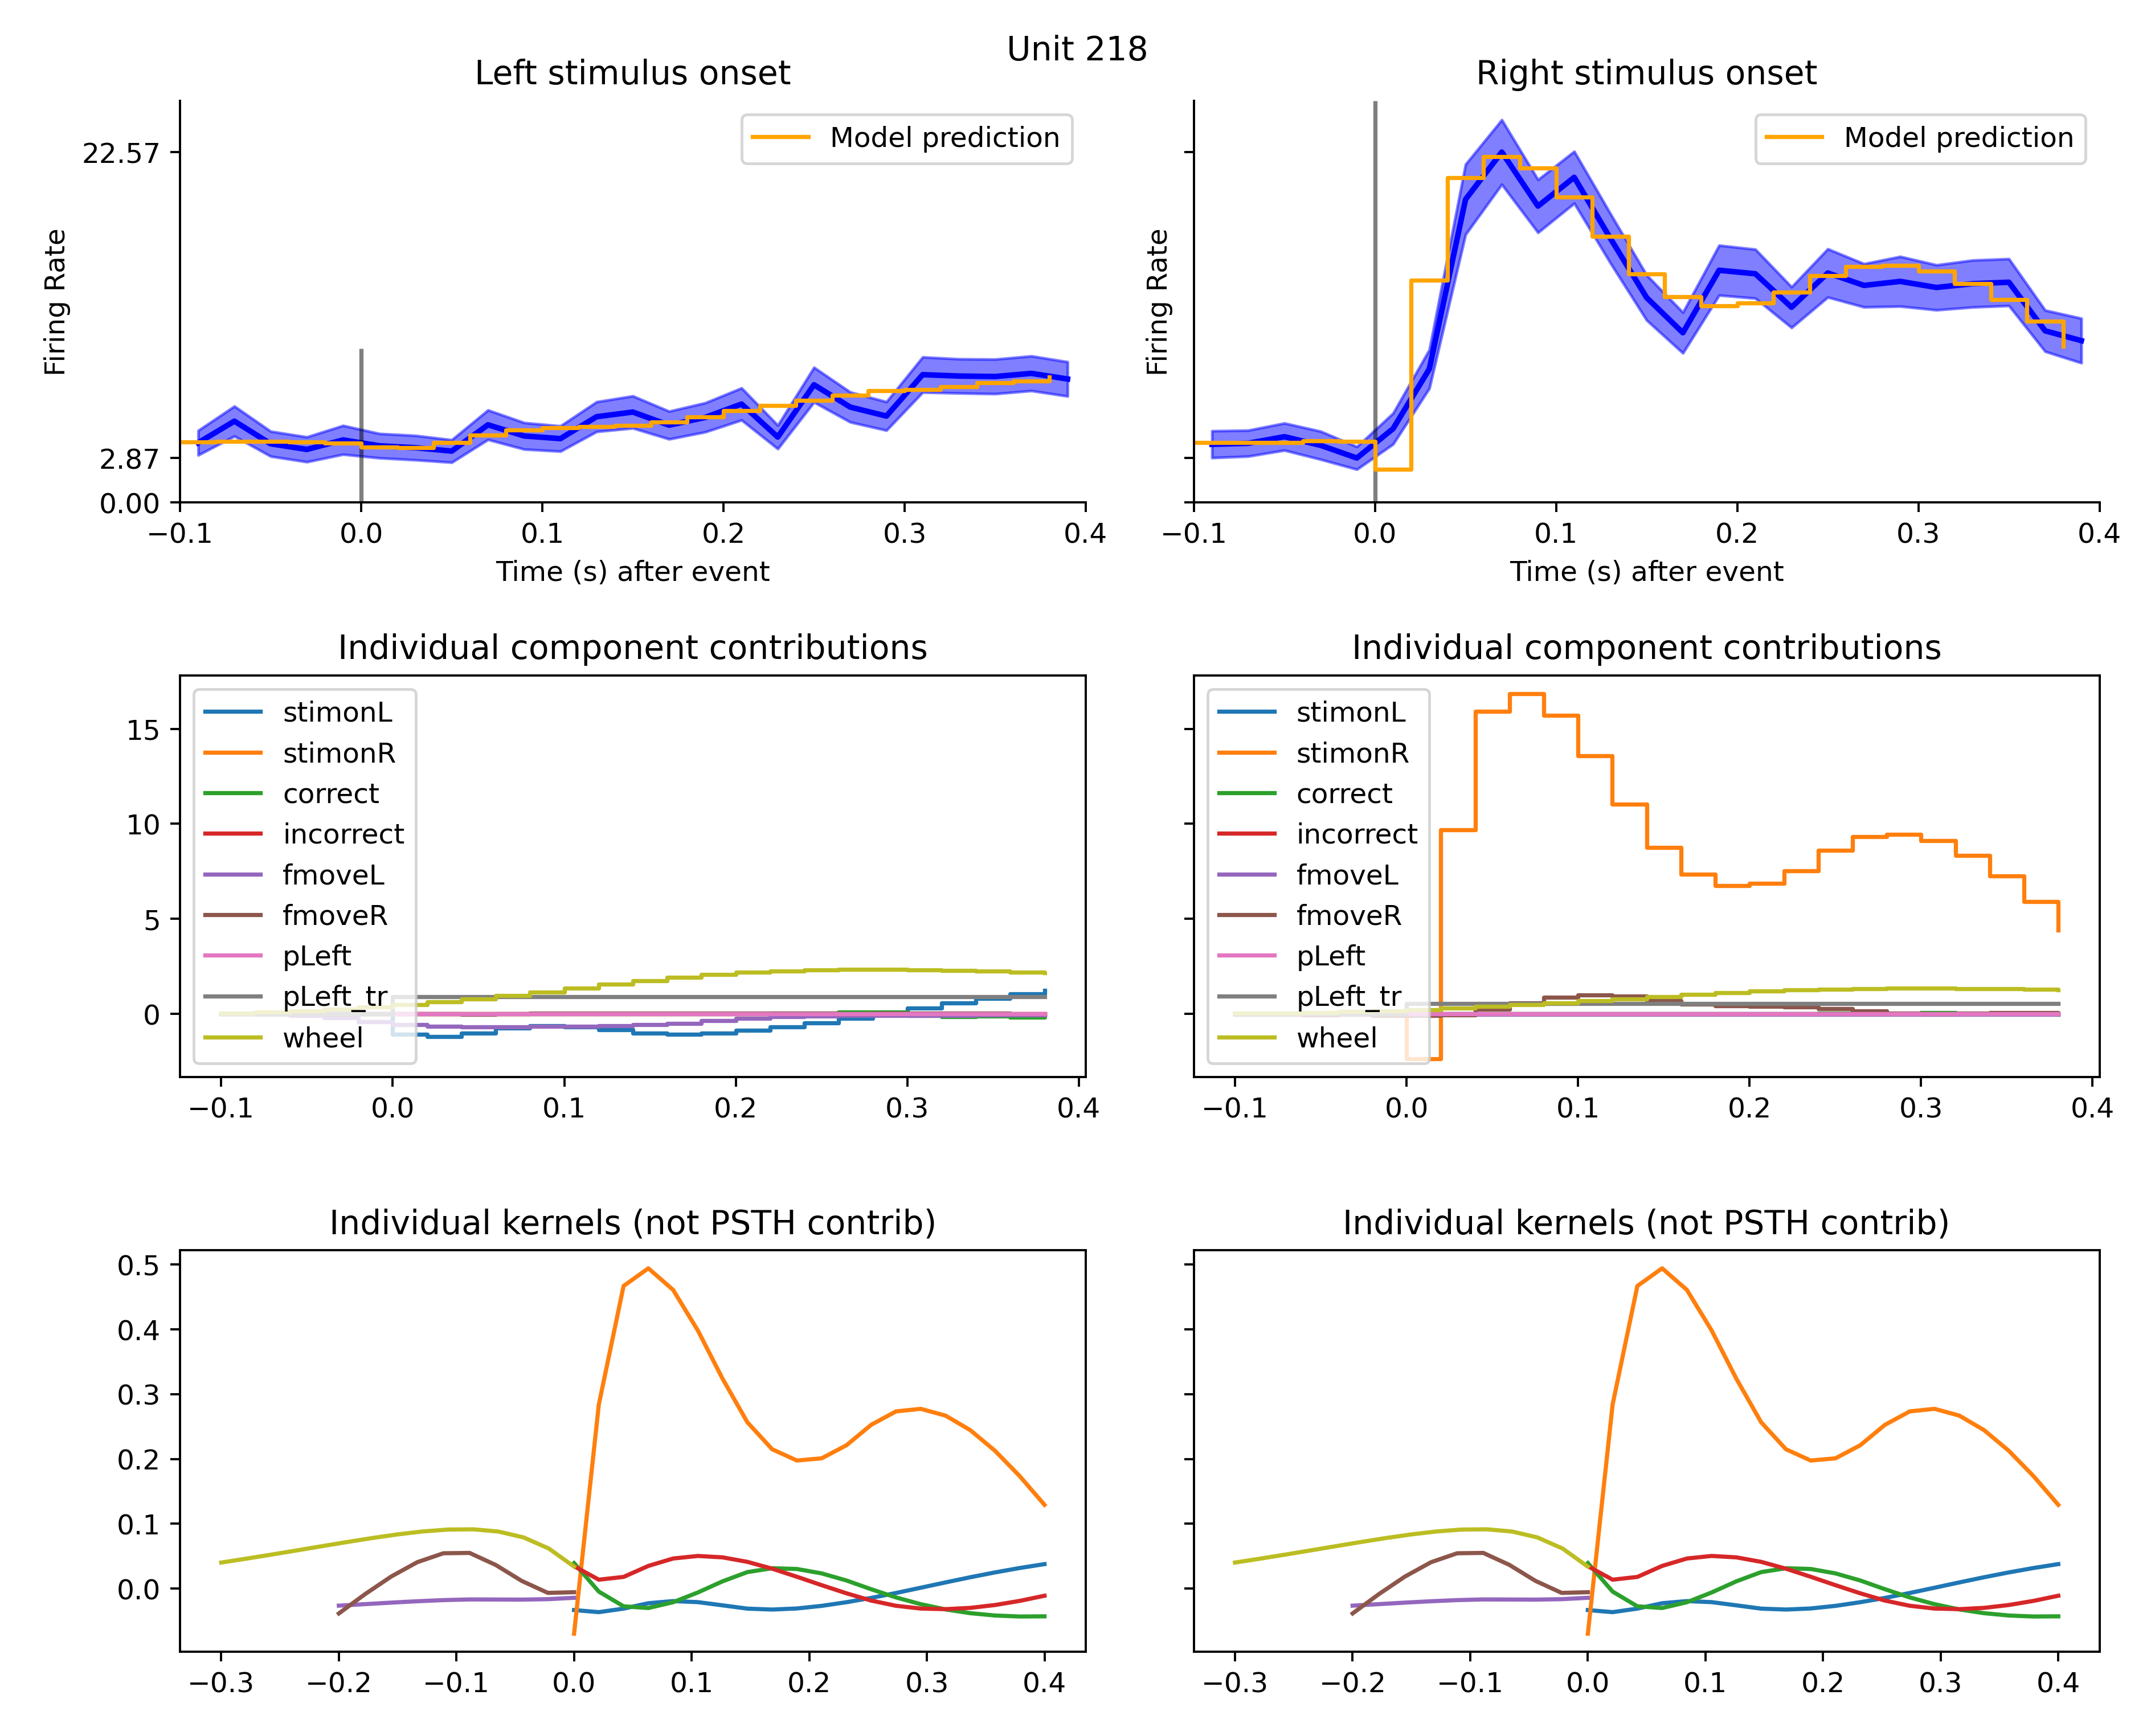

To make these plots, we use code from the [neuroencoding](https://github.com/berkgercek/neurencoding/) repository, created by Berk Gercek.


Useful links from within this repository:

- Example code to [run a GLM fit for a single session](https://github.com/berkgercek/neurencoding/blob/master/examples/modeling.py)
- Code for the [design matrix creation](https://github.com/int-brain-lab/paper-brain-wide-map/blob/encoding_rc/brainwidemap/encoding/design.py) (this is the hard part)
- Use the [Class GLMPredictor](https://github.com/int-brain-lab/paper-brain-wide-map/blob/encoding_rc/brainwidemap/encoding/glm_predict.py) to create plots

**How to install the repository**

🐍 Note: This may not work in Colab, install this on your machine instead 🪛

In [ ]:
!git clone https://github.com/berkgercek/neurencoding.git

In [ ]:
%cd /content/neurencoding
!pip install -e .

###📘 Correlate neural activity with continuous variables instead of binary

Some variables in the task are `binary` (e.g. choice, stimulus side), but some others are `continuous`.

We list below a few continuous variables:

- the `wheel speed` and `position`
- the `paw positionn`     (loading documentation [here](https://int-brain-lab.github.io/iblenv/notebooks_external/loading_video_data.html))
- the `motion energy`     (loading documentation [here](https://int-brain-lab.github.io/iblenv/notebooks_external/loading_video_data.html))

Using e.g. linear regression, you can try to decode the values of these continuous variables using neural data.

A  question that such analysis would answer would be:
 - Do neurons encode the **vigor** of movement?

### 📕 Model the behavior and see if there are neural correlates

How would you answer the questions:
- Do animal adopt a certain body posture, that is predictive of their decision?
- Where are these postures encoded in the brain ?

Use the output from the video segmentation algorithm (loading documentation [here](https://int-brain-lab.github.io/iblenv/notebooks_external/loading_video_data.html)), e.g. the paw position (`paw_R`) to see if there are any `stereotypical movements`.

Use an `unsupervised classifer` method to segregate different kinds of movement the animals makes, and assess whether there are particular patterns of occurence.

Assess whether these stereotypical movements can be `decoded` from the neural activity using the techniques of this tutorial (Encoding or Decoding).


## Read further on how to access and load the data

- [Cosyne tutorial on data access](https://colab.research.google.com/drive/1UORj9XY7JKjsHYDRCBYUuqwWO2lk_M5H#scrollTo=DTXaY02vPpl6)
- [Loading data examples](https://int-brain-lab.github.io/iblenv/loading_examples.html)